In [1]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-16.0.1"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re # 정규화
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer # 말뭉치 벡터화
from tensorflow.keras.preprocessing.sequence import pad_sequences # 리스트 길이 통일
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename = '/content/공모전_제공_데이터(1차).xlsx'
data = pd.read_excel(filename)
data

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
...,...,...,...,...,...,...,...,...,...,...
995,9958,103,카드분실된지 1분만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는데 감...,칭찬>삼성카드>카드상품,11,NaN,NaN,NaN,NaN,칭찬>삼성카드>카드상품
996,9961,2,수시로 6개월무이자할부와 링크혜택이 다른카드와 구별되는 기능이 편리함,칭찬>삼성카드>혜택,7,칭찬>삼성카드>혜택,7.0,NaN,NaN,칭찬>삼성카드>혜택
997,9962,4,무이자할부 자주 많이 주셔서감사합니다,칭찬>삼성카드>혜택,7,NaN,NaN,NaN,NaN,칭찬>삼성카드>혜택
998,9963,5,무이자혜택만족긴할부만족잘쓰고있습니다,칭찬>삼성카드>혜택,7,NaN,NaN,NaN,NaN,칭찬>삼성카드>혜택


In [ ]:
# 결측치 채워넣기
data['발화1의 우선순위'] = data['발화1의 우선순위'].fillna('')
data['발화2'] = data['발화2'].fillna('')
data['발화2의 우선순위'] = data['발화2의 우선순위'].fillna('')
data['발화3'] = data['발화3'].fillna('')
data['발화3의 우선순위'] = data['발화3의 우선순위'].fillna('')

# type 변경
data['발화1의 우선순위'] = data['발화1의 우선순위'].astype(str)

# column name 변경
data.rename(columns = {"최종분류(우선순위 가장 높은것 선택)": "최종분류"}, inplace = True)

In [ ]:
data.tail()

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류
995,9958,103,카드분실된지 1분만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는데 감...,칭찬>삼성카드>카드상품,11,,,,,칭찬>삼성카드>카드상품
996,9961,2,수시로 6개월무이자할부와 링크혜택이 다른카드와 구별되는 기능이 편리함,칭찬>삼성카드>혜택,7,칭찬>삼성카드>혜택,7,,,칭찬>삼성카드>혜택
997,9962,4,무이자할부 자주 많이 주셔서감사합니다,칭찬>삼성카드>혜택,7,,,,,칭찬>삼성카드>혜택
998,9963,5,무이자혜택만족긴할부만족잘쓰고있습니다,칭찬>삼성카드>혜택,7,,,,,칭찬>삼성카드>혜택
999,9964,7,무이자 혜택이 많아 잘쓰고있어요.,칭찬>삼성카드>혜택,7,,,,,칭찬>삼성카드>혜택


In [ ]:
data['발화_변경'] = data['발화'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거

import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "발화_변경"에 적용(.sub)시킴
    return result

apply_regular_expression(data['발화_변경'][0])

'상담직원과 빠른연결했슴좋겠어요'

In [ ]:
data.head()

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류,발화_변경
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과 빠른연결했슴좋겠어요
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,안기다리고 빨리상담되었음좋겠다
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,너무 오래기다리고 상담이 늦어져요
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과 통화가 매우 힘들다
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담받으려면오래기다리는게불편함


In [2]:
!pip install kss

     |████████████████████████████████| 65 kB 4.6 MB/s 


In [ ]:
import kss

token_text = []

for text in data['발화_변경']:
    for sent in kss.split_sentences(text):
        token_text.append(sent.strip())

token_text

['상담직원과 빠른연결했슴좋겠어요',
 '안기다리고 빨리상담되었음좋겠다',
 '너무 오래기다리고 상담이 늦어져요',
 '상담직원과  통화가  매우  힘들다',
 '상담받으려면오래기다리는게불편함',
 '상담하려면 많이기다려야하는게 불편합니다',
 '상담원이통화중이라많이기다려야해요',
 '상담직원과의연결이 빠르게연결되면촣겠습니다',
 '상담직원넘많이기다려야하는불편해요',
 '상담원 통화가너믜힘듬',
 '상담원과의 연결이빨리되었으면감사힘니다',
 '상담원이 영결이많이힘이듬',
 '번질문에 대한 답변은 상담직원 연결되기까지 기다리는것말곤없는듯',
 '상담을 하려면 좀 많이기다려야 상담사분이 나오셔서 그게좀 불편하네요',
 '상담이 다시 생겼으면',
 '상담하려하는  기다리는시간    너무길다',
 '상담직원과 빠른속도로  연결이되길 원합니다',
 '상담직원과 빠른연결부탁드립니다',
 '상담직원과통화하기가힘들다',
 '상담한번받을려면 보통분이상대기해야실질상담은분미만인데',
 '직원상담 시간너무지연됨 짜증유발',
 '상담톡이 부족',
 '상담사와 연결부분이  어려웠어요',
 '톡상담 인원을 늘려주세요요즘 같은 때에는 전화상담보다 톡상담이 더 신속하고 일처리가 빠른데 인원이 너무 적은듯매번 기다리다 일처리 못하고 그냥 지나간적이 한두번이 아닙니다',
 '지동응답불필요한안내축소 상담직원과 빠른연결을원합니다',
 '추석연휴 잘 보내세요',
 '상담원과의 대화 까지 소요되는시간이길어서힘들었음',
 '삼성카드사의 직원과 면대면하여 질문답변이 되길수있으면 좋겠습니다',
 '문자상담이나 온라인 상담이 가능한 부분이 많아졌으면 좋겠습니다',
 '상담 직원과 연결이 좀  신속 했으면 좋겟네요',
 '상담번호를  남겼는데  너무  늦게  주심이  넘 불만입니다',
 '상담직원대기시간이 짫았으면 한다',
 '고객입장에선 통화하기가 쉬웠으면합니다',
 '전용상담원이  잇엇으면',
 'ㅠㅠ전화상담좀 빠르게 되었으면좋겠어용',
 '상당직원연결이잘안됨',
 '상담원 연결이 정말 힘들었다',
 '고

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

In [ ]:
tfidf_vectorizer.fit(token_text) # 단어를 학습시킴 
tfidf_vectorizer.vocabulary_ # 단어사전을 출력 
sorted(tfidf_vectorizer.vocabulary_.items()) # 단어사전 정렬

[('ㅆㅅㅌㅊ임', 0),
 ('ㅇ번으로하세요몐트로햇으면고맙겟읍니다', 1),
 ('ㅠㅠ전화상담좀', 2),
 ('ㅡㅡ', 3),
 ('가고싶다', 4),
 ('가기해당', 5),
 ('가끔', 6),
 ('가끔씩', 7),
 ('가끔있어요그래도', 8),
 ('가끔친절하지안거나', 9),
 ('가능', 10),
 ('가능하도록', 11),
 ('가능한', 12),
 ('가능해서', 13),
 ('가려고했는데', 14),
 ('가상담할때', 15),
 ('가입한', 16),
 ('가장', 17),
 ('가장웃음목소리를', 18),
 ('가장좋은카드회사입니다', 19),
 ('가족카드관련', 20),
 ('가지', 21),
 ('간결하고', 22),
 ('간결하면', 23),
 ('간단하게좀', 24),
 ('간단한', 25),
 ('간편하게', 26),
 ('간편해서', 27),
 ('감동받았습니다', 28),
 ('감동받음친절하게', 29),
 ('감동을', 30),
 ('감동입니다항상감사합니다', 31),
 ('감동적이었음', 32),
 ('감동하는', 33),
 ('감동한적이', 34),
 ('감사', 35),
 ('감사드려요', 36),
 ('감사드림니다', 37),
 ('감사드립니다', 38),
 ('감사요', 39),
 ('감사하게', 40),
 ('감사하겠습니다', 41),
 ('감사하고', 42),
 ('감사하고요', 43),
 ('감사하네요', 44),
 ('감사하다', 45),
 ('감사하다고할게요응대', 46),
 ('감사하다는', 47),
 ('감사하였습니다', 48),
 ('감사한것이', 49),
 ('감사함니다', 50),
 ('감사함을느낌', 51),
 ('감사합니다', 52),
 ('감사합니당', 53),
 ('감사해요', 54),
 ('감사했습니다', 55),
 ('감사했어요', 56),
 ('감사했읍니다', 57),
 ('감안해서', 58),
 ('감염', 59),
 ('감정이부족함', 60),
 ('강요합니다상담원분들', 61

In [ ]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [ ]:
def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

cleaned_corpus = []
for sent in data['발화_변경']:
    cleaned_corpus.append(clean_punc(sent, punct, punct_mapping))

len(cleaned_corpus)

1000

In [ ]:
import re

def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        corpus.append(review)
    return corpus

basic_preprocessed_corpus = clean_text(cleaned_corpus)
len(basic_preprocessed_corpus)

1000

In [ ]:
type(basic_preprocessed_corpus)

list

In [3]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install soynlp
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1RNYpLE-xbMCGtiEHIoNsCmfcyJP3kLYn" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1RNYpLE-xbMCGtiEHIoNsCmfcyJP3kLYn" -o confused_loanwords.txt

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-t22kecnf
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-t22kecnf
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2255828 sha256=9d35611b26a68e0474cada554573cdbf3f0afa1ae405731d30099d856bbe07c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-g_onwamp/wheels/9b/93/81/a2a7dc8c66ede5bf30634d20635f32b95eac7ca2ea8844058b
Successfully built pykospacing


  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-zesqe7ba
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-zesqe7ba
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4870 sha256=1684b307f88acaaf39630ce19b45f8217bbc1037e5443afa3bc79ff1afd25d7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_6z808s/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
     |████████████████████████████████| 416 kB 29.4 MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3264      0 --:--:-- --:--:-- --:--:--  3238
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19779  100 19779    0     0  58345      0 --:--:-

In [ ]:
from pykospacing import Spacing
from hanspell import spell_checker
from soynlp.normalizer import *
spacing = Spacing()

In [ ]:
data['clean_발화'] = spell_preprocessed_corpus
data.head(20)

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류,발화_변경,clean_발화
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과 빠른연결했슴좋겠어요,상담직원과 빠른연결했슴좋겠어요
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,안기다리고 빨리상담되었음좋겠다,안 기다리고 빨리 상담되었으면 좋겠다
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,너무 오래기다리고 상담이 늦어져요,너무 오래 기다리고 상담이 늦어져요
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과 통화가 매우 힘들다,상담직원과 통화가 매우 힘들다
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담받으려면오래기다리는게불편함,상담받으려면 오래 기다리는 게 불편함
5,6,11435,상담하려면 많이기다려야하는게 불편합니다.,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담하려면 많이기다려야하는게 불편합니다,상담하려면 많이 기다려야 하는 게 불편합니다
6,7,12111,상담원이통화중이라많이기다려야해요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담원이통화중이라많이기다려야해요,상담원이 통화 중이라 많이 기다려야 해요
7,8,12155,상담직원과의연결이 빠르게연결되면촣겠습니다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과의연결이 빠르게연결되면촣겠습니다,상담직원과의 연결이 빠르게연결되면촣겠습니다
8,9,12595,ars상담직원넘많이기다려야하는불편해요,불만>삼성카드>상담/채널,33,불만>고객서비스>상담시스템,5,,,불만>고객서비스>상담시스템,상담직원넘많이기다려야하는불편해요,상담직원 너무 많이 기다려야 하는 불편해요
9,10,12745,상담원 통화가너믜힘듬,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담원 통화가너믜힘듬,상담원 통화가너믜힘듬


In [ ]:
def spell_check_text(texts):
    corpus = []
    for sent in texts:
        spaced_text = spacing(sent)
        spelled_sent = spell_checker.check(sent)
        checked_sent = spelled_sent.checked
        normalized_sent = repeat_normalize(checked_sent)
        corpus.append(normalized_sent)
    return corpus

spell_preprocessed_corpus = spell_check_text(basic_preprocessed_corpus)
len(spell_preprocessed_corpus)

data['clean_발화'] = spell_preprocessed_corpus
data.head()

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류,발화_변경,clean_발화
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과 빠른연결했슴좋겠어요,상담직원과 빠른연결했슴좋겠어요
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,안기다리고 빨리상담되었음좋겠다,안 기다리고 빨리 상담되었으면 좋겠다
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,너무 오래기다리고 상담이 늦어져요,너무 오래 기다리고 상담이 늦어져요
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담직원과 통화가 매우 힘들다,상담직원과 통화가 매우 힘들다
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,,,,,불만>고객서비스>상담시스템,상담받으려면오래기다리는게불편함,상담받으려면 오래 기다리는 게 불편함


In [ ]:
token_text = []

for text in data['clean_발화']:
    for sent in kss.split_sentences(text):
        token_text.append(sent.strip())

token_text

tfidf_vectorizer.fit(token_text) # 단어를 학습시킴 
tfidf_vectorizer.vocabulary_ # 단어사전을 출력 
sorted(tfidf_vectorizer.vocabulary_.items()) # 단어사전 정렬

[('ㅆㅅㅌㅊ임', 0),
 ('ㅇ번으로하세요몐트로햇으면고맙겟읍니다', 1),
 ('ㅠㅠ전화상담좀', 2),
 ('ㅡㅡ', 3),
 ('가고', 4),
 ('가기', 5),
 ('가끔', 6),
 ('가끔씩', 7),
 ('가능', 8),
 ('가능성을', 9),
 ('가능하도록', 10),
 ('가능하면', 11),
 ('가능한', 12),
 ('가능해서', 13),
 ('가능했으면', 14),
 ('가려고', 15),
 ('가상', 16),
 ('가요', 17),
 ('가입한', 18),
 ('가장', 19),
 ('가족카드', 20),
 ('가지', 21),
 ('각각', 22),
 ('간결하고', 23),
 ('간결하면', 24),
 ('간단하게', 25),
 ('간단한', 26),
 ('간편하게', 27),
 ('간편해서', 28),
 ('감동받았습니다', 29),
 ('감동받음', 30),
 ('감동을', 31),
 ('감동입니다', 32),
 ('감동적이었음', 33),
 ('감동하는', 34),
 ('감동한', 35),
 ('감사', 36),
 ('감사드려요', 37),
 ('감사드립니다', 38),
 ('감사를', 39),
 ('감사요', 40),
 ('감사하게', 41),
 ('감사하겠습니다', 42),
 ('감사하겠음', 43),
 ('감사하고', 44),
 ('감사하고요', 45),
 ('감사하네요', 46),
 ('감사하다', 47),
 ('감사하다고', 48),
 ('감사하다는', 49),
 ('감사하였습니다', 50),
 ('감사한', 51),
 ('감사함을', 52),
 ('감사합니다', 53),
 ('감사합니다ㅡ', 54),
 ('감사해요', 55),
 ('감사했습니다', 56),
 ('감사했어요', 57),
 ('감안해서', 58),
 ('감염', 59),
 ('감정이', 60),
 ('강요합니다', 61),
 ('강했어요', 62),
 ('강화로', 63),
 ('같네요', 64),
 ('같다', 65),
 ('같습니다', 6

In [4]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Cloning into 'khaiii'...
remote: Enumerating objects: 1016, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 1016 (delta 46), reused 76 (delta 29), pack-reused 877
Receiving objects: 100% (1016/1016), 33.06 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (404/404), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -

In [ ]:
stopword = pd.read_csv('stopwords.txt')

In [ ]:
stopwords = list(np.array(stopword['불용어'].tolist()))

In [ ]:
spell_preprocessed_corpus[:5]

['상담직원과 빠른연결했슴좋겠어요',
 '안 기다리고 빨리 상담되었으면 좋겠다',
 '너무 오래 기다리고 상담이 늦어져요',
 '상담직원과 통화가 매우 힘들다',
 '상담받으려면 오래 기다리는 게 불편함']

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')

word_tokens = word_tokenize(spell_preprocessed_corpus)

result = [word for word in word_tokens if not word in stopwords]

result

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


TypeError: ignored

In [ ]:
removed_stopword_corpus = remove_stopword_text(spell_preprocessed_corpus)
removed_stopword_corpus[:10]

TypeError: ignored

In [ ]:
len(removed_stopword_corpus)

1104

In [ ]:
from collections import Counter

# 말뭉치 생성
corpus = "".join(removed_stopword_corpus)
corpus

'상담/NNG 직원/NNG 빠르/VA 연결하다/VV 좋/VA안/MAG 기다리다/VV 빨리/MAG 상담되다/VV 좋/VA너무/MAG 오래/MAG 기다리다/VV 상담/NNG 늦/VA 지다/VV상담/NNG 직원/NNG 통화/NNG 매우/MAG 힘들/VA상담/NNG 받다/VV 오래/MAG 기다리다/VV 것/NNB 불편하다/VV상담하다/VV 많이/MAG 기다리다/VV 하다/VV 것/NNB 불편하다/VV상/NNG 담원/NNP 통화/NNG 중/NNB 많이/MAG 기다리다/VV 하다/VV상담/NNG 직원/NNG 연결/NNG 빠르/VA 연결되다/VV 촣/VA상담/NNG 직원/NNG 너무/MAG 많이/MAG 기다리다/VV 하다/VV 불편하다/VV상담원/NNP 통화가/NNG 너/MAG 믜/NNG 힘듬/MAG상/NNP 담원/NNG 연결/NNG 빨리/MAG 되/XSV 감사/NNG 힘다/VV상담/NNP 원/NNG 영결/NNG 많이/MAG 힘/NNG 들다/VV번/NNG 질문/NNG 대하다/VV 답변/NNG 상담/NNG 직원/NNG 연결되다/VV 기다리다/VV 것/NNB 말다/VV 없/VA 듯/NNB상담/NNG 하다/VV 좀/MAG 많이/MAG 기다리다/VV 상담사분/NNG 나오다/VV 좀/MAG 불편하다/VV상담/NNG 다시/MAG 생기다/VV상담하다/VV 하다/VV 기다리다/VV 시간/NNG 너무/MAG 길/VA상담/NNG 직원/NNG 빠르/VA 속도/NNG 연결/NNG 되다/VV 원/NNG 하/VA상담/NNG 직원/NNG 빠르/VA 연결/NNG 부탁/NNG 드리다/VV상담/NNG 직원/NNG 통화하다/VV 힘들/VA상담/NNG 한/NNG 번/NNB 받다/VV 보/NNG 통/MAG 분/NNG 상대기하다/VV 실질/NNG 상담/NNG 분/NNB 만/NNG직원/NNG 상담/NNG 시간/NNG 너무/MAG 지연되다/VV 짜증/NNG 유발/NNG상담/NNG 톡/NNG 부족/NNG상담사/NNG 연결/NNG 부분/NNG 어렵/VA톡/MAG 상담/NNG 인원/NNG 늘리다/VV 주다/VV 요즘/N

In [ ]:
new_corpus = apply_regular_expression(corpus)
new_corpus

'상담 직원 빠르 연결하다 좋안 기다리다 빨리 상담되다 좋너무 오래 기다리다 상담 늦 지다상담 직원 통화 매우 힘들상담 받다 오래 기다리다 것 불편하다상담하다 많이 기다리다 하다 것 불편하다상 담원 통화 중 많이 기다리다 하다상담 직원 연결 빠르 연결되다 촣상담 직원 너무 많이 기다리다 하다 불편하다상담원 통화가 너 믜 힘듬상 담원 연결 빨리 되 감사 힘다상담 원 영결 많이 힘 들다번 질문 대하다 답변 상담 직원 연결되다 기다리다 것 말다 없 듯상담 하다 좀 많이 기다리다 상담사분 나오다 좀 불편하다상담 다시 생기다상담하다 하다 기다리다 시간 너무 길상담 직원 빠르 속도 연결 되다 원 하상담 직원 빠르 연결 부탁 드리다상담 직원 통화하다 힘들상담 한 번 받다 보 통 분 상대기하다 실질 상담 분 만직원 상담 시간 너무 지연되다 짜증 유발상담 톡 부족상담사 연결 부분 어렵톡 상담 인원 늘리다 주다 요즘 같 때 전화 상담 톡 상담 더 신속하다 일처리 빠르 인원 너무 적 듯 매번 기다리다 일처리 못 하 그냥 지나가다 적 번지동 응답 필요하다 안내 축소 상담 직원 빠르 연결 원하다추석 연휴 잘 보내다상 담 원 대화 소요되다 시간 길 힘들삼성카드사 직원 면대 면 하다 질문 답변 되다 수 있다 좋문자 상담 온라인 상담 가능하다 부분 많 지다 좋상담 직원 연결 좀 신속하다 좋상담번호 남기다 너무 늦 주심 너무 불만 입다상담 직원 대기 시간 짫다 하다고객 입장 통화하다 쉽 하다전용 상담원 있다전화상담 좀 빠르 되다 좋상당 직원 연결 잘 안 되다상 담 원 연결 정말 힘들고객 기다리다 않다 안내 직원 확대 부탁하다상 담 원 연결 어렵 번이상 시도하다 함주말 시 상담사 연결 직접 되다골 드 회원 전용 전화 상담원 비치되다 있다 좋주말 운영하다 하다주말 공휴일 이용 가능하다 좋주말 공휴일 급하 업무 처리하다 수 있다 비상 상담원 배치 필요하다실시간 채팅 상담 만들다 주다통화 연결 대기 시간 길상 담원 전화 연결 되다 때 대기 시간 많이 길상 담 원 연결 대기 시간 짧아다 지다 좋상 

In [ ]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
okt = Okt()
nouns = okt.nouns(apply_regular_expression(new_corpus))
print(nouns)

['상담', '직원', '상담', '상담', '늦', '지다', '상담', '직원', '통화', '매우', '상담', '것', '상담', '것', '상', '담', '통화', '중', '상담', '직원', '연결', '연결', '촣', '상담', '직원', '상담', '통화', '너', '믜', '상', '담', '연결', '감사', '상담', '원', '영결', '힘', '번', '질문', '대하', '답변', '상담', '직원', '연결', '것', '듯', '상담', '좀', '상담사', '좀', '상담', '다시', '생기', '상담', '시간', '길', '상담', '직원', '속도', '연결', '원', '상담', '직원', '연결', '부탁', '상담', '직원', '통화', '상담', '번', '보', '통', '분', '상대', '기하', '실질', '상담', '분', '직원', '상담', '시간', '지연', '짜증', '유발', '상담', '톡', '부족', '상담사', '연결', '부분', '톡', '상담', '인원', '요즘', '때', '전화', '상담', '톡', '상담', '더', '처리', '인원', '적', '듯', '매번', '처리', '못', '그냥', '적', '번', '지동', '응답', '안내', '축소', '상담', '직원', '연결', '추석', '연휴', '상', '담', '원', '대화', '소요', '시간', '길', '카드', '사', '직원', '면대', '면', '질문', '답변', '수', '문자', '상담', '온라인', '상담', '부분', '지다', '상담', '직원', '연결', '좀', '상담', '번호', '늦', '주심', '불만', '입다', '상담', '직원', '대기', '시간', '짫다', '고객', '입장', '통화', '상담', '전화', '상담', '좀', '상당', '직원', '연결', '안', '상', '담', '원', '연결', '정말', '고객', '안내', '직원', '

In [ ]:
# 빈도 탐색
counter = Counter(nouns)

In [ ]:
counter.most_common(10)

[('상담', 447),
 ('연결', 127),
 ('통화', 103),
 ('시간', 102),
 ('카드', 92),
 ('감사', 85),
 ('화면', 81),
 ('것', 76),
 ('직원', 74),
 ('친절', 74)]

In [ ]:
available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('상담', 447),
 ('연결', 127),
 ('통화', 103),
 ('시간', 102),
 ('카드', 92),
 ('감사', 85),
 ('화면', 81),
 ('직원', 74),
 ('친절', 74),
 ('대기', 63)]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopword]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(data['발화_변경'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [ ]:
bow_vect.shape

(1000, 726)

In [ ]:
# "단어" - "총 등장 횟수" Matching

word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가기': 1,
 '가끔': 4,
 '가능': 1,
 '가능성': 1,
 '가상': 1,
 '가알': 1,
 '가요': 1,
 '가입': 1,
 '가장': 5,
 '가족': 1,
 '가지': 2,
 '가타': 1,
 '각각': 1,
 '감동': 7,
 '감사': 86,
 '감안': 1,
 '감염': 1,
 '감정': 1,
 '강요': 1,
 '강화': 1,
 '개선': 4,
 '개월': 1,
 '개월무': 1,
 '개인정보': 1,
 '거나': 1,
 '거의': 1,
 '건강': 2,
 '게뭐': 1,
 '결과': 1,
 '결론': 1,
 '결부': 1,
 '결재': 1,
 '결제': 1,
 '경우': 8,
 '경청': 1,
 '경향': 1,
 '경험': 3,
 '계설': 1,
 '계속': 5,
 '계심': 1,
 '계좌': 1,
 '고객': 62,
 '고급': 1,
 '고마움': 2,
 '고생': 2,
 '곧바로': 2,
 '골드': 9,
 '골절': 1,
 '공감': 2,
 '공부': 4,
 '공휴일': 2,
 '과정': 2,
 '관련': 2,
 '관리': 2,
 '광고': 4,
 '괜시리': 1,
 '교육': 7,
 '구경만': 1,
 '구매': 1,
 '구별': 1,
 '구성': 2,
 '구입': 2,
 '구체': 1,
 '구현': 1,
 '국민': 1,
 '국민카드': 4,
 '권유': 3,
 '권한': 1,
 '그것': 2,
 '그게': 2,
 '그냥': 4,
 '그대로': 2,
 '근무': 2,
 '근저당': 1,
 '글쎄요': 1,
 '글씨': 1,
 '금고': 1,
 '금도': 1,
 '금사항': 1,
 '금세': 1,
 '긍지': 1,
 '기간': 3,
 '기계': 3,
 '기네': 1,
 '기능': 2,
 '기다림': 1,
 '기대': 1,
 '기도': 1,
 '기분': 25,
 '기사': 1,
 '기억': 6,
 '기업': 1,
 '기업인': 1,
 '기재': 1,
 '기존': 2,
 '기초': 1,
 '기침': 1,
 '기타': 1,


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [ ]:
print(tf_idf_vect.shape)

(1000, 726)


In [ ]:
vect.vocabulary_

{'가기': 0,
 '가끔': 1,
 '가능': 2,
 '가능성': 3,
 '가상': 4,
 '가알': 5,
 '가요': 6,
 '가입': 7,
 '가장': 8,
 '가족': 9,
 '가지': 10,
 '가타': 11,
 '각각': 12,
 '감동': 13,
 '감사': 14,
 '감안': 15,
 '감염': 16,
 '감정': 17,
 '강요': 18,
 '강화': 19,
 '개선': 20,
 '개월': 21,
 '개월무': 22,
 '개인정보': 23,
 '거나': 24,
 '거의': 25,
 '건강': 26,
 '게뭐': 27,
 '결과': 28,
 '결론': 29,
 '결부': 30,
 '결재': 31,
 '결제': 32,
 '경우': 33,
 '경청': 34,
 '경향': 35,
 '경험': 36,
 '계설': 37,
 '계속': 38,
 '계심': 39,
 '계좌': 40,
 '고객': 41,
 '고급': 42,
 '고마움': 43,
 '고생': 44,
 '곧바로': 45,
 '골드': 46,
 '골절': 47,
 '공감': 48,
 '공부': 49,
 '공휴일': 50,
 '과정': 51,
 '관련': 52,
 '관리': 53,
 '광고': 54,
 '괜시리': 55,
 '교육': 56,
 '구경만': 57,
 '구매': 58,
 '구별': 59,
 '구성': 60,
 '구입': 61,
 '구체': 62,
 '구현': 63,
 '국민': 64,
 '국민카드': 65,
 '권유': 66,
 '권한': 67,
 '그것': 68,
 '그게': 69,
 '그냥': 70,
 '그대로': 71,
 '근무': 72,
 '근저당': 73,
 '글쎄요': 74,
 '글씨': 75,
 '금고': 76,
 '금도': 77,
 '금사항': 78,
 '금세': 79,
 '긍지': 80,
 '기간': 81,
 '기계': 82,
 '기네': 83,
 '기능': 84,
 '기다림': 85,
 '기대': 86,
 '기도': 87,
 '기분': 88,
 '기사': 89,
 '기억

In [ ]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{320: '상담', 590: '직원', 651: '통화', 197: '매우', 433: '연결', 14: '감사', 441: '영결', 484: '이듬', 595: '질문', 1...


In [ ]:
from wordcloud import WordCloud

In [ ]:
wordcloud = WordCloud(font_path='/content/NanumGothic.ttf', background_color='white').generate(new_corpus)

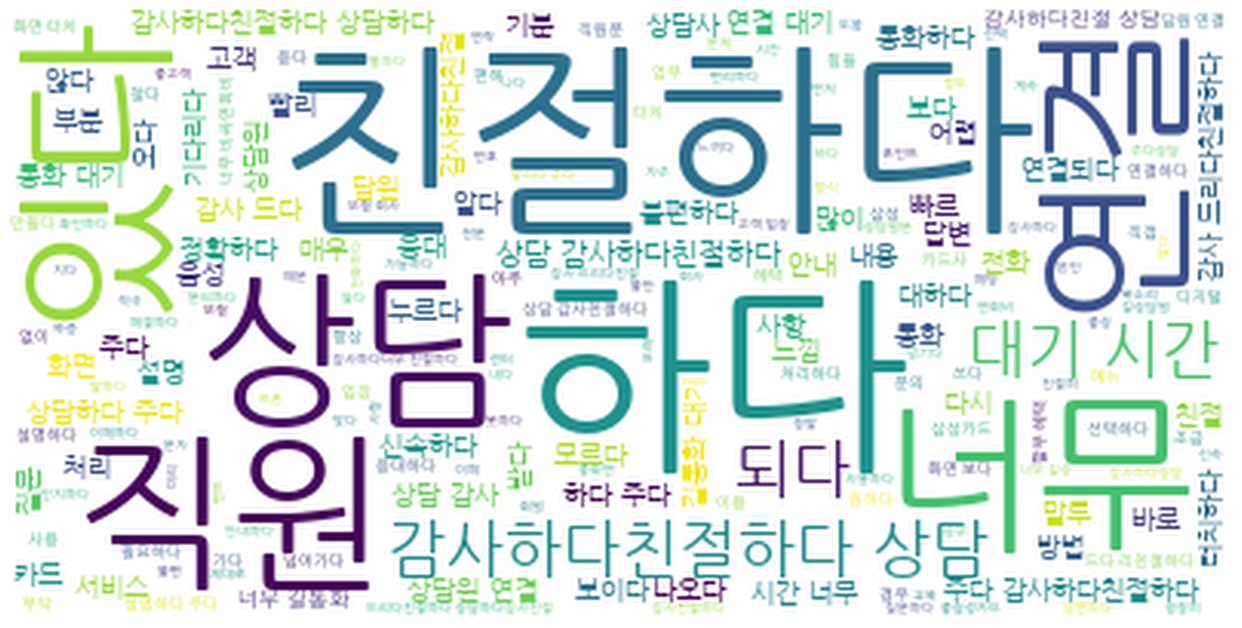

In [ ]:
plt.figure(figsize=(22,22)) #이미지 사이즈 지정
plt.imshow(wordcloud, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off') #x y 축 숫자 제거
plt.show()